Imports

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import cv2
from PIL import Image, ImageFilter
import scipy
import seaborn as sns
from scipy.ndimage import rotate
sns.set(color_codes=True)

Image Paths to Change

In [ ]:
# The path with ALL of the data, up through the "Leaves" folder
directory = "C:\\Users\\ladob\\Downloads\\An Image Dataset of  Citrus Fruit and Leaves for Detection and Classification of Diseases\\Citrus Plant Dataset\\Citrus\\Leaves"
# Path to a Single Image in Directory
image_path = r"C:\Users\ladob\Downloads\An Image Dataset of  Citrus Fruit and Leaves for Detection and Classification of Diseases\Citrus Plant Dataset\Citrus\Leaves\Black spot\b (93).png"
# PNG Path - Path to single PNG Outside of Directory
png_path = r"C:\Users\ladob\Downloads\b(93).png"
# JPG Path - Location to Read JPG of PNG to Outside of Directory
jpg_path = r"C:\Users\ladob\Downloads\b(93).jpg"

Data

In [ ]:
# Other Data Import Method:
citrus_leaves = tfds.load('citrus_leaves', split = 'train')
len(citrus_leaves)
# This method is not used below, but is an example of how to read in the data more easily

594

In [ ]:
# Parameters
img_height = 256
img_width = 256
batch_size = 32

In [ ]:
# Training Data
training = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 609 files belonging to 5 classes.
Using 488 files for training.


In [ ]:
# Validation Data
validation = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 609 files belonging to 5 classes.
Using 121 files for validation.


In [ ]:
# Classes
class_names = training.class_names
print(class_names)

['Black spot', 'Melanose', 'canker', 'greening', 'healthy']


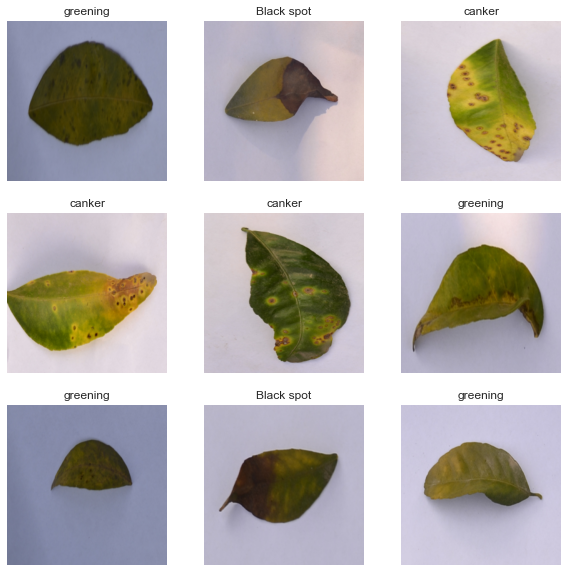

In [ ]:
# Examples
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Size of Batch
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


Preprocessing Examples

(-0.5, 255.5, 255.5, -0.5)

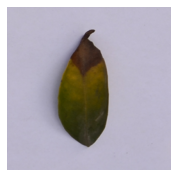

In [ ]:
# Get Image
img = Image.open(image_path) 
image = np.array(img)

# Show Image
plt.figure(figsize=(3, 3))

plt.imshow(image.astype("uint8"))
plt.axis("off")

In [ ]:
# Create JPG of Image
image_png = Image.open(png_path)
image_png.save(jpg_path)

(-0.5, 255.5, 255.5, -0.5)

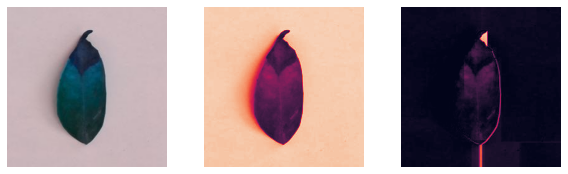

In [ ]:
# Top Hat Method

# Getting the Kernel
filterSize = (72, 72)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize)
  
# Input Image
orig_image = cv2.imread(jpg_path)
input_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
  
# Apply Top-Hat Operation
tophat_img = cv2.morphologyEx(input_image, cv2.MORPH_TOPHAT, kernel)
  
#cv2.imshow("original", input_image)
#cv2.imshow("tophat", tophat_img)
#cv2.waitKey(5000)

plt.figure(figsize=(10, 10))

ax1 = plt.subplot(3, 3, 1)
plt.imshow(orig_image.astype("uint8"))
plt.axis("off")

ax2 = plt.subplot(3, 3, 2)
plt.imshow(input_image.astype("uint8"))
plt.axis("off")

ax3 = plt.subplot(3, 3, 3)
plt.imshow(tophat_img.astype("uint8"))
plt.axis("off")
# Note: Outputs Grayscale or Binary Image

In [ ]:
# Augmentation Methods

def show_img(img, ax):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)

    
def plot_grid(imgs, nrows, ncols, figsize=(10, 10)):
    assert len(imgs) == nrows*ncols, f"Number of images should be {nrows}x{ncols}"
    _, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        show_img(img, ax)

def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img

def rotate_img(img, angle, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

def random_crop(img, crop_size=(10, 10)):
    assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
    img = img.copy()
    w, h = img.shape[:2]
    x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
    img = img[y:y+crop_size[0], x:x+crop_size[1]]
    return img

def translate(img, shift=10, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img

def distort(img, orientation='horizontal', func=np.sin, x_scale=0.05, y_scale=5):
    assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
    assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
    assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
    assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
    img_dist = img.copy()
    
    def shift(x):
        return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
        for i in range(img.shape[orientation.startswith('ver')]):
            if orientation.startswith('ver'):
                img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
            else:
                img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
    return img_dist

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


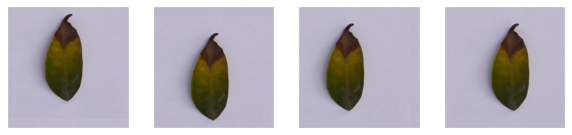

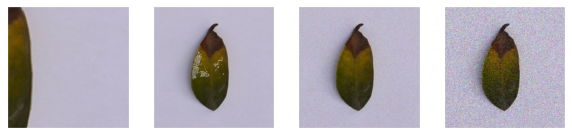

In [ ]:
img = np.array(plt.imread(image_path))

plot_grid([translate(img, direction='up', shift=20),
           translate(img, direction='down', shift=20), 
           translate(img, direction='left', shift=20),
           translate(img, direction='right', shift=20)],
           1, 4, figsize=(10, 5))

plot_grid([random_crop(img, crop_size = (110, 110)),
           rotate_img(img, angle = .30), 
           gaussian_noise(img),
           gaussian_noise(img, sigma = 0.1)],
           1, 4, figsize=(10, 5))

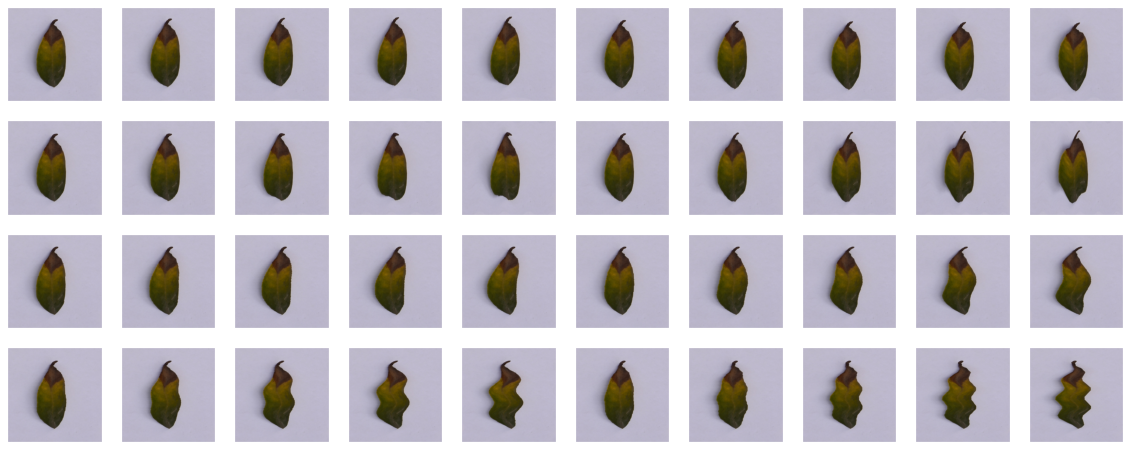

In [ ]:
imgs_distorted = []
for ori in ['ver', 'hor']:
    for x_param in [0.01, 0.02, 0.03, 0.04]:
        for y_param in [2, 4, 6, 8, 10]:
            imgs_distorted.append(distort(img, orientation=ori, x_scale=x_param, y_scale=y_param))

plot_grid(imgs_distorted, 4, 10, figsize=(20, 8))

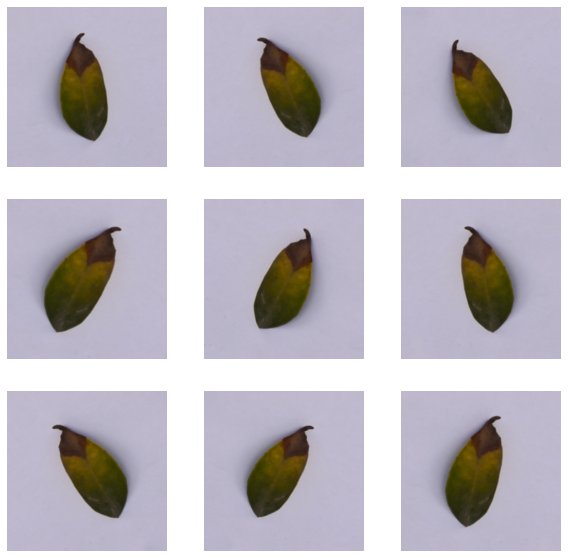

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal", input_shape = (img_height, img_width, 3)), # Augmentation
  layers.RandomRotation(0.1),# Augmentation
  layers.RandomZoom(0.1), # Augmentation
])

img = np.array(plt.imread(image_path))
image = tf.cast(tf.expand_dims(img, 0), tf.float32)

plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

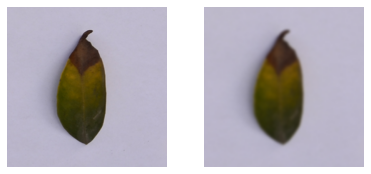

In [ ]:
# Gaussian Function

# Open Image
image = Image.open(image_path) 
orig_image = np.array(image)

# Blur Image
new_image = image.filter(ImageFilter.GaussianBlur)
new_image = np.array(new_image)

# Displaying the image
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(3, 3, 1)
plt.imshow(orig_image.astype("uint8"))
plt.axis("off")

ax2 = plt.subplot(3, 3, 2)
plt.imshow(new_image.astype("uint8"))
plt.axis("off")

Segmentation

C:\Users\ladob\AppData\Local\Temp\ipykernel_27892\2091261433.py:13: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  cv_image_gray = chan_vese(image_gray, max_iter=100, extended_output=True)


(-0.5, 255.5, 255.5, -0.5)

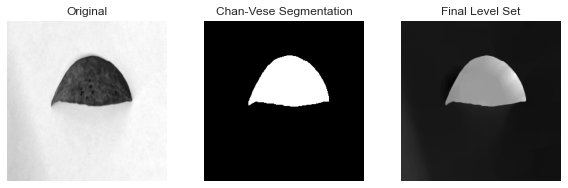

In [ ]:
# Weighted Segmentation

import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data, img_as_float
from skimage.segmentation import chan_vese
 
# Image
n = 6
image = images[n].numpy().astype("uint8")
image_gray = rgb2gray(image)
 
# Chan VESE Segmentation
cv_image_gray = chan_vese(image_gray, max_iter=100, extended_output=True)

# Displaying the Images
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(3, 3, 1)
plt.imshow(image_gray, cmap = "gray")
plt.title("Original")
plt.axis("off")

ax2 = plt.subplot(3, 3, 2)
plt.imshow(cv_image_gray[0], cmap="gray")
plt.title("Chan-Vese Segmentation")
plt.axis("off")

ax2 = plt.subplot(3, 3, 3)
plt.imshow(cv_image_gray[1],cmap="gray")
plt.title("Final Level Set")
plt.axis("off")

In [ ]:
# Saliency Map

def input_img(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def normalize_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

(-0.5, 223.5, 223.5, -0.5)

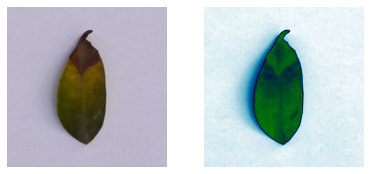

In [ ]:
input_img = input_img(image_path)
input_img = tf.keras.applications.densenet.preprocess_input(input_img)

image = Image.open(img_path) 
orig_image = np.array(image)

plt.figure(figsize=(10, 10))

ax1 = plt.subplot(3, 3, 1)
plt.imshow(orig_image.astype("uint8"))
plt.axis("off")

ax2 = plt.subplot(3, 3, 2)
plt.imshow(normalize_image(input_img[0]), cmap = "ocean")
plt.axis("off")

Image Analysis Model

In [ ]:
# Sequential Model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./256, input_shape = (img_height, img_width, 3)), # Rescaling
  data_augmentation, # Augmentation
  layers.Conv2D(16, 3, padding='same', activation='relu'), # Convolutional Layer
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'), # Convolutional Layer
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), # Convolutional Layer
  layers.MaxPooling2D(),
  layers.Flatten(), # Flatten
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # Output Layer
])

In [ ]:
# Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Check Model Results

In [ ]:
# Results
epochs = 5
history = model.fit(training, validation_data = validation, epochs = epochs)

Epoch 1/5
16/16 [==============================] - 8s 400ms/step - loss: 1.7131 - accuracy: 0.2971 - val_loss: 1.3241 - val_accuracy: 0.4050
Epoch 2/5
16/16 [==============================] - 7s 407ms/step - loss: 1.2804 - accuracy: 0.4119 - val_loss: 1.1234 - val_accuracy: 0.5455
Epoch 3/5
16/16 [==============================] - 7s 402ms/step - loss: 1.0398 - accuracy: 0.5307 - val_loss: 1.0365 - val_accuracy: 0.4876
Epoch 4/5
16/16 [==============================] - 7s 410ms/step - loss: 0.9403 - accuracy: 0.5758 - val_loss: 0.8038 - val_accuracy: 0.6694
Epoch 5/5
16/16 [==============================] - 7s 419ms/step - loss: 0.8147 - accuracy: 0.6639 - val_loss: 0.7420 - val_accuracy: 0.6198


In [ ]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(acc)
print(val_acc)

[0.29713115096092224, 0.41188523173332214, 0.5307376980781555, 0.5758196711540222, 0.6639344096183777]
[0.40495866537094116, 0.5454545617103577, 0.4876033067703247, 0.6694214940071106, 0.6198347210884094]


1/1 [==============================] - 0s 23ms/step
Leaf 20 in the training set is predicted to be canker
Leaf 20 in the training set is actually canker


(-0.5, 255.5, 255.5, -0.5)

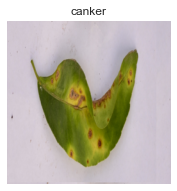

In [ ]:
# Predict
n = 20

img = np.array(images[n])
image = tf.cast(tf.expand_dims(img, 0), tf.float32)
yhat = model.predict(image)

yhat_label = np.argmax(yhat)

print(f"Leaf {n} in the training set is predicted to be " + class_names[yhat_label])
print(f"Leaf {n} in the training set is actually " + str(class_names[labels[n]]))

plt.figure(figsize=(3, 3))

plt.imshow(img.astype("uint8"))
plt.title(class_names[labels[n]])
plt.axis("off")

Citations:

https://www.tensorflow.org/tutorials/images/classification#load_data_using_a_keras_utility

https://www.geeksforgeeks.org/top-hat-and-black-hat-transform-using-python-opencv/

https://www.geeksforgeeks.org/apply-a-gauss-filter-to-an-image-with-python/

https://knowyourdata-tfds.withgoogle.com/#dataset=citrus_leaves&tab=STATS&select=default_segment.citrus_leaves.label.value&sort_asc=true&expanded_groups=kyd

https://data.mendeley.com/datasets/3f83gxmv57/2

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6731382/
https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd

https://www.analyticsvidhya.com/blog/2022/06/introduction-to-saliency-map-in-an-image-with-tensorflow-2-x-api/
https://www.geeksforgeeks.org/image-segmentation-using-pythons-scikit-image-module/